In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load processed bike rental data with station information CSV file
bike_dat_raw = pd.read_csv("seoul_bike_rental_data_processed_2406.csv", encoding="cp949")

# Check the shape of processed data
bike_dat_raw.shape

(4984352, 29)

In [3]:
# Check irregular rides of 0 minutes used or 0 meters riden, Exclude them.
print((bike_dat_raw['use_meters']==0).value_counts())
print()
print((bike_dat_raw['use_minutes']==0).value_counts())

bike_dat = bike_dat_raw[(bike_dat_raw['use_meters']!=0) & (bike_dat_raw['use_minutes']!=0)].copy()
print()
print(bike_dat.shape)

False    4752525
True      231827
Name: use_meters, dtype: int64

False    4861062
True      123290
Name: use_minutes, dtype: int64

(4740293, 29)


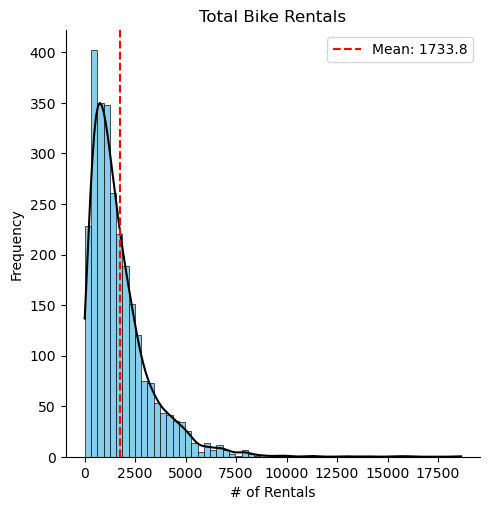

In [13]:
# 1. Total of bike rentals for each station
station_rent_counts = bike_dat.groupby(['rent_station_id'], as_index=False).size()
station_rent_mean = station_rent_counts['size'].mean()

sns.displot(station_rent_counts['size'], kde=True, bins = 60, color="black", facecolor='skyblue')
plt.axvline(station_rent_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {station_rent_mean:.1f}')

plt.title(f"Total Bike Rentals")
plt.xlabel("# of Rentals")
plt.ylabel("Frequency")
plt.legend(loc="upper right", shadow=False)

plt.savefig('images/1_total_bike_rentals_each_station.png', bbox_inches='tight')
plt.show()

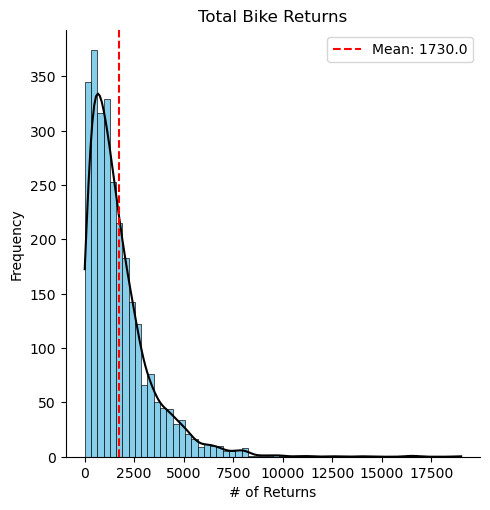

In [15]:
# 2. # of bike returns for each station
station_return_counts = bike_dat.groupby(['return_station_id'], as_index=False).size()
station_return_mean = station_return_counts['size'].mean()

sns.displot(station_return_counts['size'], kde=True, bins = 60, color="black", facecolor='skyblue')
plt.axvline(station_return_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {station_return_mean:.1f}')

plt.title(f"Total Bike Returns")
plt.xlabel("# of Returns")
plt.ylabel("Frequency")
plt.legend(loc="upper right", shadow=False)

plt.savefig('images/2_total_bike_returns_each_station.png', bbox_inches='tight')
plt.show()

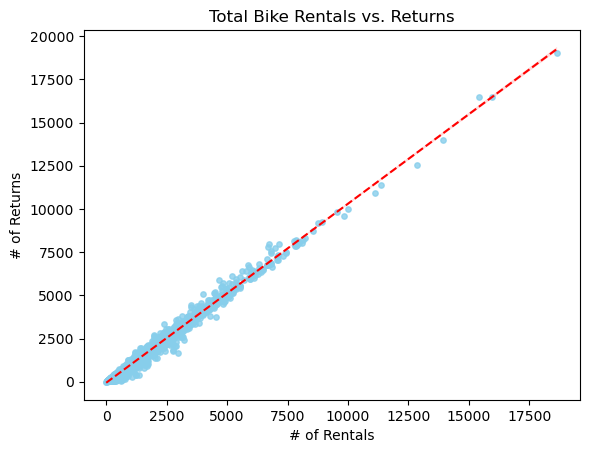

In [17]:
# 3. Total rentals vs. total returns for each station

station_counts = (
    station_rent_counts.rename(columns={
        'rent_station_id': 'station_id', 
        'size': 'rent'
    })
    .merge(
        station_return_counts.rename(columns={
            'return_station_id': 'station_id', 
            'size': 'return'
        }), 
        how='left', 
        on=['station_id']
    )
)

sns.regplot(data=station_counts, x='rent', y='return', color='skyblue', line_kws={'color': 'red', 'linestyle': '--', 'linewidth': 1.5}, scatter_kws={'s':15})

plt.title("Total Bike Rentals vs. Returns")
plt.xlabel("# of Rentals")
plt.ylabel("# of Returns")

plt.savefig('images/3_rentals_vs_returns_each_station.png', bbox_inches='tight')
plt.show()

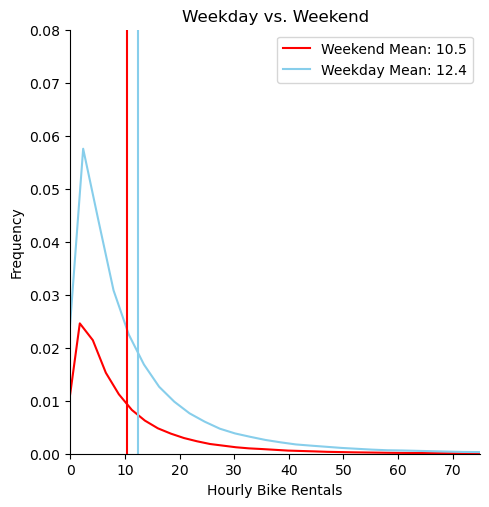

In [19]:
# 4. Weekday vs. Weekend hourly bike rental

wday_rent_counts = bike_dat.groupby(['rent_station_id', 'rent_is_weekend', 'rent_weekday', 'rent_hour'], as_index=False).size()

weekend_mean = wday_rent_counts[wday_rent_counts['rent_is_weekend'] == True]['size'].mean()
weekday_mean = wday_rent_counts[wday_rent_counts['rent_is_weekend'] == False]['size'].mean()

sns.displot(data=wday_rent_counts, x="size", hue="rent_is_weekend", kind="kde", palette={True: 'red', False: 'skyblue'}, legend=False)

plt.xlim(0,75)
plt.ylim(0,0.08)
plt.axvline(weekend_mean, color='red',  label=f'Weekend Mean: {weekend_mean:.1f}')
plt.axvline(weekday_mean, color='skyblue',  label=f'Weekday Mean: {weekday_mean:.1f}')

plt.title("Weekday vs. Weekend")
plt.xlabel("Hourly Bike Rentals")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

plt.savefig('images/4_weekday_vs_weekend_hourly_bike_rental.png', bbox_inches='tight')
plt.show()

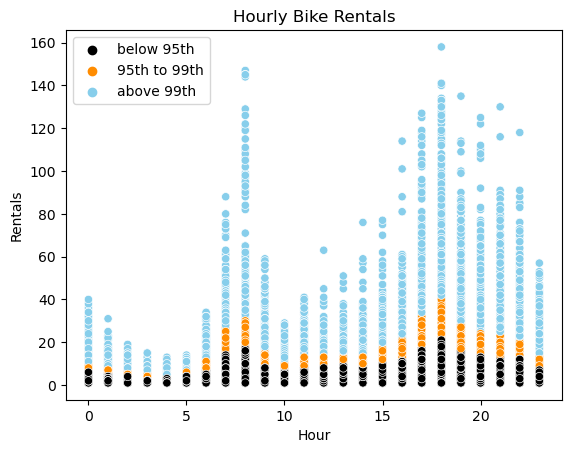

In [21]:
# 5. Hourly bike rentals for each station

hourly_rent_counts = bike_dat.groupby(['rent_station_id', 'rent_date', 'rent_hour'], as_index=False).size()
hourly_rent_counts['quantile_95'] = hourly_rent_counts['rent_hour'].map(hourly_rent_counts.groupby(['rent_hour'])['size'].quantile(0.95))
hourly_rent_counts['quantile_99'] = hourly_rent_counts['rent_hour'].map(hourly_rent_counts.groupby(['rent_hour'])['size'].quantile(0.99))

# Define a custom function to assign quantile groups
def assign_quantile_group(row):
    if row['size'] <= row['quantile_95']:
        return 'below 95th'
    elif row['size'] <= row['quantile_99']:
        return '95th to 99th'
    else:
        return 'above 99th'

hourly_rent_counts['quantile_range'] = hourly_rent_counts.apply(assign_quantile_group, axis=1)

sns.scatterplot(data=hourly_rent_counts, x='rent_hour', y='size', hue='quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'})

plt.title("Hourly Bike Rentals")
plt.xlabel("Hour")
plt.ylabel("Rentals")
plt.legend(loc='upper left')

plt.savefig('images/5_hourly_bike_rentals_each_station.png', bbox_inches='tight')
plt.show()

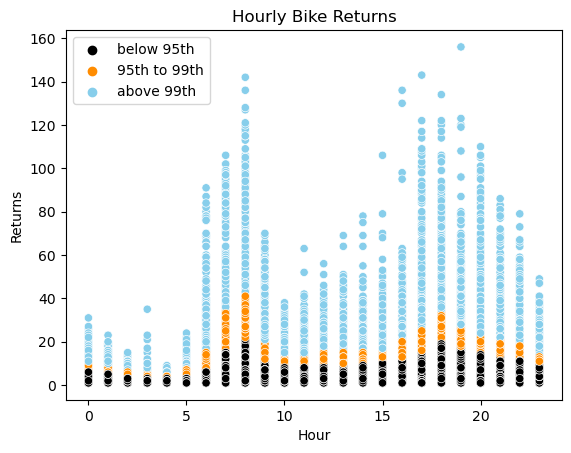

In [23]:
# 6. Hourly bike returns for each station

hourly_return_counts = bike_dat.groupby(['return_station_id', 'return_date', 'return_hour'], as_index=False).size()
hourly_return_counts['quantile_95'] = hourly_return_counts['return_hour'].map(hourly_return_counts.groupby(['return_hour'])['size'].quantile(0.95))
hourly_return_counts['quantile_99'] = hourly_return_counts['return_hour'].map(hourly_return_counts.groupby(['return_hour'])['size'].quantile(0.99))

hourly_return_counts['quantile_range'] = hourly_return_counts.apply(assign_quantile_group, axis=1)

sns.scatterplot(data=hourly_return_counts, x='return_hour', y='size', hue='quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'})

plt.title("Hourly Bike Returns")
plt.xlabel("Hour")
plt.ylabel("Returns")
plt.legend(loc='upper left')

plt.savefig('images/6_hourly_bike_returns_each_station.png', bbox_inches='tight')
plt.show()

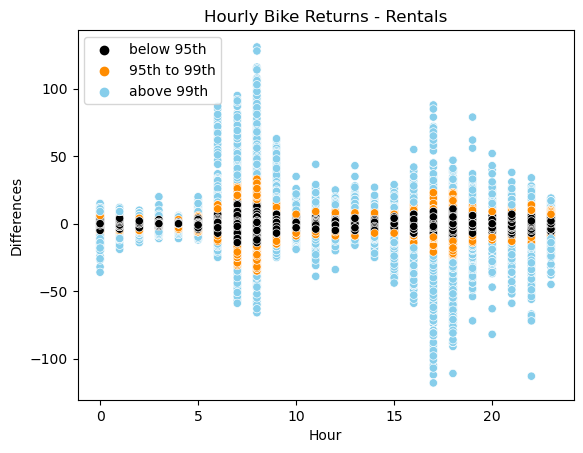

In [25]:
# 7. Hourly bike returns for each station

hourly_counts = (
    hourly_rent_counts.rename(columns={
        'rent_station_id': 'station_id', 
        'rent_date': 'date',
        'rent_hour': 'hour',
        'size': 'rent'
    })
    .merge(
        hourly_return_counts.rename(columns={
            'return_station_id': 'station_id', 
            'return_date': 'date', 
            'return_hour': 'hour', 
            'size': 'return'
        }), 
        how='left', 
        on=['station_id', 'date', 'hour']
    )
)

hourly_counts['diff'] = hourly_counts['return'] - hourly_counts['rent']
hourly_counts['abs_diff'] = abs(hourly_counts['diff'])
hourly_counts['quantile_95'] = hourly_counts['hour'].map(hourly_counts.groupby(['hour'])['abs_diff'].quantile(0.95))
hourly_counts['quantile_99'] = hourly_counts['hour'].map(hourly_counts.groupby(['hour'])['abs_diff'].quantile(0.99))

def assign_quantile_group_diff(row):
    if row['abs_diff'] <= row['quantile_95']:
        return 'below 95th'
    elif row['abs_diff'] <= row['quantile_99']:
        return '95th to 99th'
    else:
        return 'above 99th'

hourly_counts['quantile_range'] = hourly_counts.apply(assign_quantile_group_diff, axis=1)



sns.scatterplot(data=hourly_counts, x='hour', y='diff', hue='quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'}, hue_order = ['below 95th', '95th to 99th', 'above 99th'])

plt.title("Hourly Bike Returns - Rentals")
plt.xlabel("Hour")
plt.ylabel("Differences")
plt.legend(loc="upper left")

plt.savefig('images/7_difference_return_and_rental_each_station.png', bbox_inches='tight')
plt.show()

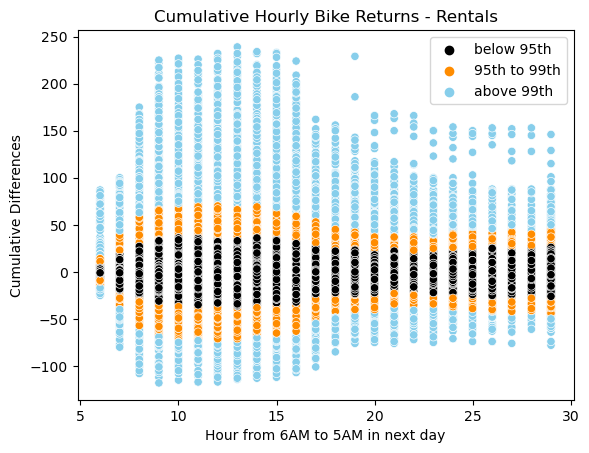

In [27]:
# 8. Cumulative differences of hourly bike returns and rentals for each station

hourly_counts['hour_from_6'] = hourly_counts['hour'].apply(lambda x: x if x >= 6 else x + 24) 
hourly_counts = hourly_counts.sort_values(by='hour_from_6')

hourly_counts['diff_cumsum'] = hourly_counts.groupby(['station_id', 'date'])['diff'].cumsum()
hourly_counts['abs_diff_cumsum'] = abs(hourly_counts['diff_cumsum'])

hourly_counts['quantile_95'] = hourly_counts['hour'].map(hourly_counts.groupby(['hour'])['abs_diff_cumsum'].quantile(0.95))
hourly_counts['quantile_99'] = hourly_counts['hour'].map(hourly_counts.groupby(['hour'])['abs_diff_cumsum'].quantile(0.99))

def assign_quantile_group_diff(row):
    if row['abs_diff_cumsum'] <= row['quantile_95']:
        return 'below 95th'
    elif row['abs_diff_cumsum'] <= row['quantile_99']:
        return '95th to 99th'
    else:
        return 'above 99th'

hourly_counts['quantile_range'] = hourly_counts.apply(assign_quantile_group_diff, axis=1)



sns.scatterplot(data=hourly_counts, x='hour_from_6', y='diff_cumsum', hue='quantile_range', palette={'below 95th': 'black', '95th to 99th': 'darkorange', 'above 99th': 'skyblue'}, hue_order = ['below 95th', '95th to 99th', 'above 99th'])

plt.title("Cumulative Hourly Bike Returns - Rentals")
plt.xlabel("Hour from 6AM to 5AM in next day")
plt.ylabel("Cumulative Differences")
plt.legend(loc='upper right')

plt.savefig('images/8_cumulative_difference_return_and_rental_each_station.png', bbox_inches='tight')
plt.show()

In [29]:
# folium map visualizations
import requests
import json
import folium
import branca.colormap as cm

r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
    
c = r.content
seoul_geo = json.loads(c)

In [33]:
# Average Bike rentals
hourly_rent_counts_sample = bike_dat.groupby(['rent_station_id', 'rent_station_latitude', 'rent_station_longitude'], as_index=False).size()

hourly_rent_counts_sample = hourly_rent_counts_sample.groupby(
    ['rent_station_id', 'rent_station_latitude', 'rent_station_longitude']
).agg(
    size=('size', 'mean')
).reset_index()

hourly_rent_counts_sample

,rent_station_id,rent_station_latitude,rent_station_longitude,size
0,ST-10,37.552746,126.918617,2200.0
1,ST-1000,37.510380,126.866798,2588.0
2,ST-1002,37.529900,126.876541,4665.0
3,ST-1003,37.539551,126.828300,1231.0
4,ST-1004,37.514099,126.831001,784.0
...,...,...,...,...
2729,ST-993,37.521511,126.857384,1714.0
2730,ST-994,37.529163,126.872749,2548.0
2731,ST-995,37.510597,126.857323,401.0
2732,ST-996,37.524334,126.850548,326.0


In [35]:
# 9. folium map - Average Bike rentals

colormap = cm.LinearColormap(
    colors=['blue', 'purple', 'white', 'yellow', 'orange', 'red'],
    vmin=hourly_rent_counts_sample['size'].min(),
    vmax=hourly_rent_counts_sample['size'].max(), 
    index= np.quantile(hourly_rent_counts_sample['size'], q =[i / 5 for i in range(0, 6)])
)


m = folium.Map(
    location=[37.55708, 126.9902],     
    zoom_start=12, 
    scrollWheelZoom=False,
    fill_opacity=0,
    tiles='cartodbpositron',      
)

folium.GeoJson(seoul_geo, name='지역구', fillOpacity= 0, weight = 0.6).add_to(m)

for idx, geo_df_row in hourly_rent_counts_sample.iterrows() :
    folium.Circle(radius=5, location=[geo_df_row['rent_station_latitude'], geo_df_row['rent_station_longitude']], color=colormap(geo_df_row['size'])).add_to(m)
    
colormap.caption = 'Average Bike Rentals in June 24'

m.add_child(colormap)

m